In [1]:
from datasets.utils.logging import set_verbosity_info
set_verbosity_info()

from datasets import load_dataset, Audio, DownloadConfig
from huggingface_hub import get_token

tok = get_token()
dcfg = DownloadConfig(resume_download=True)

ds = load_dataset(
    "mozilla-foundation/common_voice_17_0",
    data_dir="sw",
    revision="refs/convert/parquet",
    token=tok,
    download_config=dcfg,
)
ds = ds.cast_column("audio", Audio(sampling_rate=16000))
print(ds)

/Users/zuzamakowska/Documents/Africa/Project/Low-resource-languages/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No config specified, defaulting to the single config: common_voice_17_0/default
Using custom data configuration default-d20c9c50bd16512f
Found cached dataset common_voice_17_0 (/Users/zuzamakowska/.cache/huggingface/datasets/mozilla-foundation___common_voice_17_0/default-d20c9c50bd16512f/0.0.0/91fadf4081526b3cf5edcf0157d15a949a2012a0)


DatasetDict({
    train: Dataset({
        features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment', 'variant'],
        num_rows: 46494
    })
    validation: Dataset({
        features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment', 'variant'],
        num_rows: 12251
    })
    test: Dataset({
        features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment', 'variant'],
        num_rows: 12253
    })
})


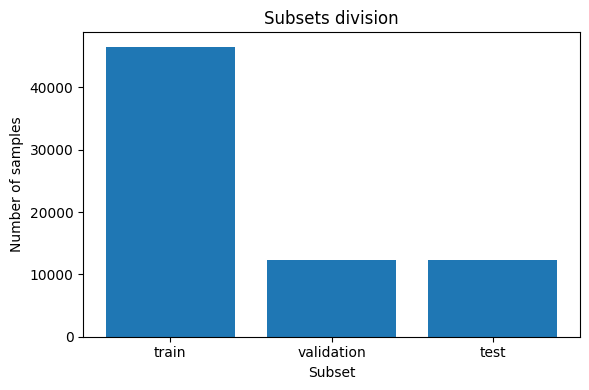

In [2]:
import matplotlib.pyplot as plt

split_sizes = {split: len(ds[split]) for split in ds.keys()}

plt.figure(figsize=(6, 4))
plt.bar(split_sizes.keys(), split_sizes.values())
plt.title("Subsets division")
plt.xlabel("Subset")
plt.ylabel("Number of samples")
plt.tight_layout()
plt.show()

In [3]:
from datasets import concatenate_datasets

ds_all = concatenate_datasets([ds["train"], ds["validation"], ds["test"]])

print(ds_all)
print("All sampels:", len(ds_all))

Dataset({
    features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment', 'variant'],
    num_rows: 70998
})
All sampels: 70998


In [4]:
print('COLUMNS')
for col in ds_all.column_names:
    print(col)

COLUMNS
client_id
path
audio
sentence
up_votes
down_votes
age
gender
accent
locale
segment
variant


In [5]:
import pandas as pd

df = pd.DataFrame(ds_all.remove_columns(['audio']))
df.columns

Index(['client_id', 'path', 'sentence', 'up_votes', 'down_votes', 'age',
       'gender', 'accent', 'locale', 'segment', 'variant'],
      dtype='object')

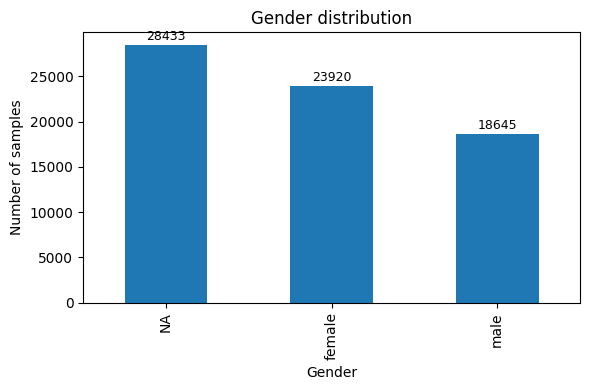

In [6]:
import numpy as np

df["gender"] = (
    df["gender"]
    .str.lower()
    .replace({
        "male_masculine": "male",
        "female_feminine": "female",
        "gender": np.nan,
        "": np.nan
    })
)

gender_counts = df['gender'].fillna('NA').value_counts()

ax = gender_counts.plot(kind='bar', figsize=(6,4))

plt.title('Gender distribution')
plt.xlabel('Gender')
plt.ylabel('Number of samples')

for i, v in enumerate(gender_counts.values):
    plt.text(i, v + 200, str(v), ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

age
teens         184
twenties    34451
thirties     6043
fourties     1195
fifties       383
sixties       452
NA          28290
Name: count, dtype: int64


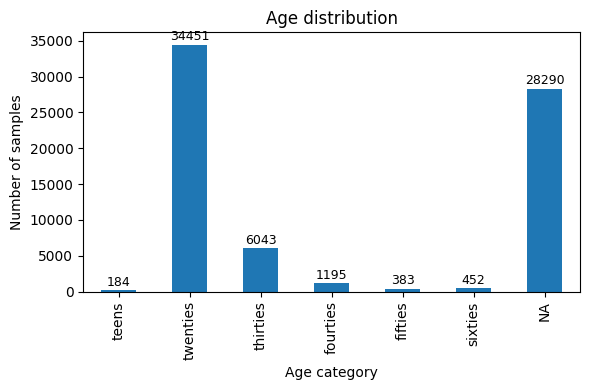

In [7]:
# import numpy as np

df["age"] = (
    df["age"]
    .str.lower()
    .replace({
        "": np.nan
    })
)

age_counts = df['age'].fillna('NA').value_counts()

order = ['teens', 'twenties', 'thirties', 'fourties', 'fifties', 'sixties', 'NA']
age_counts = age_counts.reindex(order)

print(age_counts)

age_counts.plot(kind='bar', figsize=(6,4))

plt.title('Age distribution')
plt.xlabel('Age category')
plt.ylabel('Number of samples')

for i, v in enumerate(age_counts.values):
    plt.text(i, v + 200, str(v), ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()


In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from datasets import Audio
import soundfile as sf  # pip install soundfile

# 1) Upewnij się, że NIE dekodujesz audio (żeby uniknąć torchcodec/ffmpeg)
ds_all = ds_all.cast_column("audio", Audio(decode=False))

# 2) Weź ścieżki z kolumny 'audio' (pewniejsze niż 'path')
audio_meta = ds_all["audio"]               # list[dict], każdy ma m.in. 'path'
paths = [m["path"] for m in audio_meta]

# (opcjonalnie) szybka diagnoza:
print("Przykładowe ścieżki:", paths[:3])
print("Istnieją?:", [os.path.exists(p) for p in paths[:3]])

# 3) Trwałości z nagłówków (bez dekodowania całego pliku)
def safe_duration(p):
    try:
        return sf.info(p).duration  # szybkie, czyta tylko nagłówki
    except Exception:
        return np.nan

lengths = np.array([safe_duration(p) for p in paths], dtype=np.float32)
lengths = lengths[~np.isnan(lengths)]

# 4) Jeśli nadal pusto – przerwij z czytelną diagnozą
if lengths.size == 0:
    raise RuntimeError(
        "Nie udało się odczytać długości żadnego pliku.\n"
        "Sprawdź, czy ścieżki istnieją (os.path.exists), czy masz 'soundfile' "
        "z obsługą FLAC/MP3 oraz czy cast_column(Audio(decode=False)) został wykonany na ds_all."
    )

# 5) Statystyki i wykresy
print("🎧 Długości nagrań [s]:")
print(f"  n={len(lengths)}  min={lengths.min():.2f}  p5={np.percentile(lengths,5):.2f}  "
      f"median={np.median(lengths):.2f}  mean={lengths.mean():.2f}  "
      f"p95={np.percentile(lengths,95):.2f}  max={lengths.max():.2f}")

plt.figure(figsize=(8,4))
plt.hist(lengths, bins=60, edgecolor="black")
plt.title("Audio length distribution")
plt.xlabel("Duration [seconds]")
plt.ylabel("Number of samples")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,2.6))
plt.boxplot(lengths, vert=True, showfliers=True)
plt.title("Boxplot of audio sample lengths")
plt.ylabel("Duration [seconds]")
plt.tight_layout()
plt.show()

# ECDF – wygodne do doboru paddingu
x = np.sort(lengths)
y = np.arange(1, len(x)+1) / len(x)
plt.figure(figsize=(8,4))
plt.plot(x, y)
plt.title("ECDF of audio durations")
plt.xlabel("Duration [seconds]")
plt.ylabel("Cumulative share of samples")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

pad_s = float(np.percentile(lengths, 95))
print(f"✅ Proponowany maks. czas wejścia (padding/truncation): ~{pad_s:.2f} s (p95)")


Przykładowe ścieżki: ['common_voice_sw_37083859.mp3', 'common_voice_sw_37083863.mp3', 'common_voice_sw_37084247.mp3']
Istnieją?: [False, False, False]


RuntimeError: Nie udało się odczytać długości żadnego pliku.
Sprawdź, czy ścieżki istnieją (os.path.exists), czy masz 'soundfile' z obsługą FLAC/MP3 oraz czy cast_column(Audio(decode=False)) został wykonany na ds_all.